#**Fundamentos de machine learning**
----

##**Preparación**
----

In [15]:
import pandas as pd

scopus = pd.read_csv("https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/scopus-papers.csv")
scopus['Author Keywords']

0       Geo-location data; Human mobility; Resilience;...
1       Language analysis; LIWC; Moral foundations the...
2       Gravity model; Media ecosystem; News spreading...
3       Centrality measures; Community Structure; Infl...
4       Cholesterol; Diabetes; Digital purchase record...
                              ...                        
1897    ARPEGE’; Conceptual modelling; ESDA; Geovizual...
1898    Research questions; Spatial data; Usability; U...
1899    Data integration; Data wrapping; ISO; Metadata...
1900                                                  NaN
1901                                                  NaN
Name: Author Keywords, Length: 1902, dtype: object

##**Descripción del problema**
---

La columna `'Author Keywords'` contiene las palabras claves de un conjunto de artículos extraído de Scopus. Estas palabras clave son consideradas descriptores del contenido del artículo, por lo que su análisis permite establecer el contenido conceptual de un cuerpo de literatura. De ahí que muchas técnicas de estadística y aprendizaje de máquinas sean empleadas para su análisis.

En este ejercicio, usted empleará los conocimientos adquiridos en el curso para construir un gráfico análitico comúnmente usado para el análisis comparativo de palabras que representan conceptos. Véase por ejemplo https://tlab.it/en/allegati/help_en_online/msvd.htm

1. Determine las 100 palabras clave más frecuentes. Utilice las funciones de Pandas para manipular el archivo, realizar el conteo a partir de los datos de la columna 'Author Keywords'. Como evidencia de este punto imprima las primeras y las últimas 5 palabras de este grupo de 100 palabras, y su frecuencia.

2. Construya la matriz documento-termino. Las filas son los documentos y las columnas son las 100 palabras clave más frecuentes. La matriz debería estar poblada de unos y ceros. Debe eliminar las filas que corresponden a los documentos que no usan ninguna de las 100 palabras clave más frecuentes. Como evidencia verifique que la suma de las columnas de la matriz documento-término es igual a la frecuencia computada para cada palabra en el punto anterior.

3. Construya la matriz de co-ocurrencias. En esta matriz, las filas y las columnas corresponden a las palabras claves. La diagonal es el total de veces que aparece la respectiva palabra. Los demas elementos de la matriz corresponden a las veces que aparece la palabra A con la palabra B en un mismo documento. esta matriz puede calcularse como transpuesta(A) * A, donde A es la matriz docuemnto-término. Como evidencia, grafique un mapa de calor, como por ejemplo, los obtenidos al usar seaborn. 

4. Para visualizar las relaciones de las palabras clave (cercanía), se puede reducir la dimensionalidad de la matriz de co-occurrencias a dos componentes usando SVD (o MSD), y graficar las palabras clave a partir de las coordenadas obtenidas. Un ejemplo se presenta a continuación (extraido del manual de usuario de T-LAB). El tamaño del texto es proporcional a la frecuencia de las palabras clave. Construya un gráfico similar a partir de la matriz de co-occurrencias que fue obtenida en el punto anterior.

![tlab](https://tlab.it/en/allegati/help_en_online/tlab_image/svd05.gif)

##**Punto 1**

1. **Determine las 100 palabras clave más frecuentes. Utilice las funciones de Pandas para manipular el archivo, realizar el conteo a partir de los datos de la columna 'Author Keywords'. Como evidencia de este punto imprima las primeras y las últimas 5 palabras de este grupo de 100 palabras, y su frecuencia.**

Inicialmente se realiza un preprocesamiento a los datos de esta columna, colocando los datos en minuscula, realizando un particionamiento con split y por último rellenando datos faltantes con espacios en blanco para no generar problemas en el procesamiento

In [16]:
scopus['Author Keywords']=scopus['Author Keywords'].str.lower()
scopus['Author Keywords']=scopus['Author Keywords'].str.split(";")
scopus['Author Keywords']=scopus['Author Keywords'].fillna("")
scopus['Author Keywords']

0       [geo-location data,  human mobility,  resilien...
1       [language analysis,  liwc,  moral foundations ...
2       [gravity model,  media ecosystem,  news spread...
3       [centrality measures,  community structure,  i...
4       [cholesterol,  diabetes,  digital purchase rec...
                              ...                        
1897    [arpege’,  conceptual modelling,  esda,  geovi...
1898    [research questions,  spatial data,  usability...
1899    [data integration,  data wrapping,  iso,  meta...
1900                                                     
1901                                                     
Name: Author Keywords, Length: 1902, dtype: object

Se genera una lista que contenga todos los elementos de cada fila para realizar el conteo de las palabras más frecuentes. Se realiza un `strip()` para eliminar espacios en blanco y que las palabras se consideren diferentes por estos, y se unen las palabras separadas con un underline. 

Por ultimo se hace el conteo y se presenta en un datframe Word-Frequency. 

In [17]:
full_list = []  # list containing all words of all texts
for elmnt in scopus['Author Keywords']:  # loop over lists in df
    full_list += elmnt  # append elements of lists to full list



prueba = pd.Series(full_list)
prueba = prueba.str.strip()
prueba= prueba.str.replace(" ","_")



val_counts = prueba.value_counts()[:100].sort_values(ascending=False) # make temporary Series to count
val_counts=val_counts.to_frame()
val_counts = val_counts.set_axis(['Frequency'], axis=1, inplace=False)
val_counts.reset_index(level=0, inplace=True)
val_counts = val_counts.rename(columns={'index': 'Word'})
val_counts

,Word,Frequency
0,big_data,167
1,data_mining,134
2,machine_learning,57
3,clustering,41
4,big_data_analytics,37
...,...,...
95,spark,6
96,privacy_preservation,6
97,marketing,6
98,recommender_systems,6


##**Punto 2**

2. **Construya la matriz documento-termino. Las filas son los documentos y las columnas son las 100 palabras clave más frecuentes. La matriz debería estar poblada de unos y ceros. Debe eliminar las filas que corresponden a los documentos que no usan ninguna de las 100 palabras clave más frecuentes. Como evidencia verifique que la suma de las columnas de la matriz documento-término es igual a la frecuencia computada para cada palabra en el punto anterior.**

Por facilidad se vuelve a importar el scopus, debido a que el anterior posee preprocesamiento que puede generar problemas. 

Se crea un ciclo for que le asigna un valor de 1 a las palabras presentes en las columnas (las 100 más repetidas) y 0 a las que no estan en la lista.

In [4]:
scopus2 = pd.read_csv("https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/scopus-papers.csv")
scopus2['Author Keywords']


matrix_tf=pd.DataFrame(columns=val_counts['Word'])

matrix_tf['Author Keywords']=scopus2['Author Keywords'].fillna("").str.lower().str.split(";").apply(lambda x:[i.strip().replace(' ','_') for i in x])

for i in matrix_tf.columns:
  matrix_tf[i] = matrix_tf.apply(lambda x: 1 if i in x['Author Keywords'] else 0, axis=1)

matrix_tf.pop('Author Keywords')

matrix_tf

Word,big_data,data_mining,machine_learning,clustering,big_data_analytics,classification,business_intelligence,metadata,social_media,mapreduce,...,community_detection,infrastructure,scalability,urban_form,wikipedia,spark,privacy_preservation,marketing,recommender_systems,open_access
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1899,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se hace la comparación con la obtenida en el primer punto

In [5]:
matrix_tf[matrix_tf.columns].sum().sum()

1585

In [6]:
val_counts['Frequency'].sum()

1586

##**Punto 3**

3. **Construya la matriz de co-ocurrencias. En esta matriz, las filas y las columnas corresponden a las palabras claves. La diagonal es el total de veces que aparece la respectiva palabra. Los demas elementos de la matriz corresponden a las veces que aparece la palabra A con la palabra B en un mismo documento. esta matriz puede calcularse como transpuesta(A) * A, donde A es la matriz docuemnto-término. Como evidencia, grafique un mapa de calor, como por ejemplo, los obtenidos al usar seaborn.**

In [7]:
matrix_tf_transpose = matrix_tf.transpose()
matrix_tf_transpose=matrix_tf_transpose.dot(matrix_tf)
matrix_tf_transpose

Word,big_data,data_mining,machine_learning,clustering,big_data_analytics,classification,business_intelligence,metadata,social_media,mapreduce,...,community_detection,infrastructure,scalability,urban_form,wikipedia,spark,privacy_preservation,marketing,recommender_systems,open_access
Word,,,,,,,,,,,,,,,,,,,,,
big_data,167,16,12,3,4,7,5,0,2,18,...,1,0,3,0,1,3,2,1,0,0
data_mining,16,134,13,10,10,12,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
machine_learning,12,13,57,0,8,8,3,0,3,1,...,0,0,0,0,0,1,0,0,0,0
clustering,3,10,0,41,0,4,0,0,0,2,...,0,0,1,0,0,0,0,0,0,0
big_data_analytics,4,10,8,0,37,0,3,0,3,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spark,3,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,6,0,0,0,0
privacy_preservation,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,0,0
marketing,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,0


### **Mapa de Calor**

Se usa la libreria de `Seaborn` para realizar el mapa de calor, con el fin de que esta sea mucho más visible y para posteriores calculos se realiza una estandarización de los datos. 

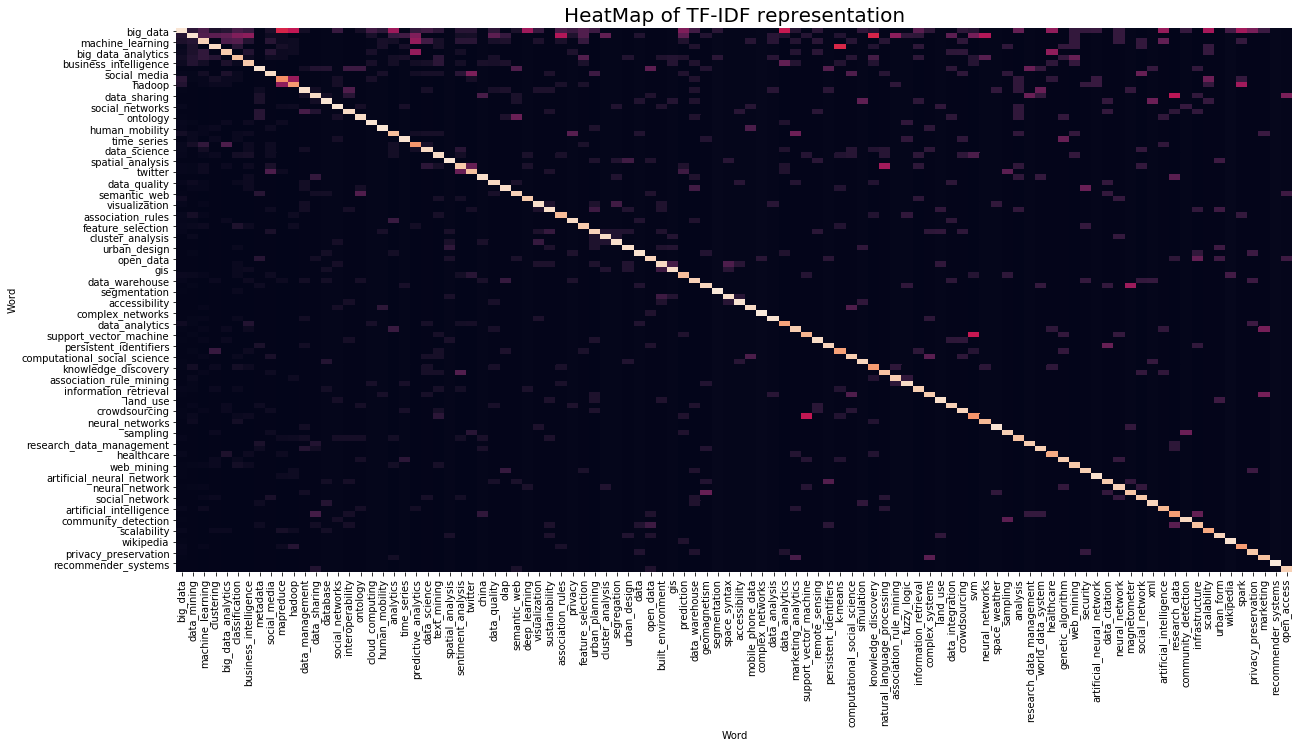

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler(
    # -------------------------------------------------------------------------
    # If True, center the data before scaling.
    with_mean=True,
    # -------------------------------------------------------------------------
    # If True, scale the data to unit variance (or equivalently, unit standard
    # deviation).
    with_std=True,
)
#tf_idf=standardScaler.fit_transform(matrix_tf_transpose.values)
tf_idf = pd.DataFrame(standardScaler.fit_transform(matrix_tf_transpose),columns = matrix_tf_transpose.columns,index=matrix_tf_transpose.columns)

f, ax = plt.subplots(figsize=(20, 10))
cmap = sns.color_palette("Blues")



ax = sns.heatmap(tf_idf,cbar=False).set_title('HeatMap of TF-IDF representation',fontsize=20)


Se usa `plotly` para comparar, sin embargo la gráfica apropiada a nivel de información contenida es la realizada con `seaborn`. 

In [18]:
import plotly.graph_objects as go

def df_to_plotly(df):
    return {'z': df.values.tolist(),
            'x': df.columns.tolist(),
            'y': df.index.tolist()}

import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(df_to_plotly(tf_idf)))
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.show()

## **Punto 4**

4. **Para visualizar las relaciones de las palabras clave (cercanía), se puede reducir la dimensionalidad de la matriz de co-occurrencias a dos componentes usando SVD (o MSD), y graficar las palabras clave a partir de las coordenadas obtenidas. Un ejemplo se presenta a continuación (extraido del manual de usuario de T-LAB). El tamaño del texto es proporcional a la frecuencia de las palabras clave. Construya un gráfico similar a partir de la matriz de co-occurrencias que fue obtenida en el punto anterior.**

Se usa MSD para llevar los datos de una dimensioón superior a una inferior, esto con el fin de gráficar los datos en un espacio bidimensional. 

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS


pdToList = list(val_counts['Word'])

X_proj = MDS().fit_transform(tf_idf)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



Se construye un dataframe que aloje los resultados de la aplicación del algoritmo de MDS, y que permita agregar la palabra asociada y su frecuencia. 

In [11]:
X_proj

df_proj = pd.DataFrame(X_proj, columns = ['Column_A','Column_B'])
freq=val_counts['Frequency']
df_proj['Frequency']=freq.values
df_proj['Word']=pdToList
df_proj

,Column_A,Column_B,Frequency,Word
0,-16.571378,10.121976,167,big_data
1,0.235815,17.384136,134,data_mining
2,-3.910962,11.985682,57,machine_learning
3,-11.076750,-6.291122,41,clustering
4,-5.449720,-10.825214,37,big_data_analytics
...,...,...,...,...
95,-1.988702,0.172430,6,spark
96,5.771813,1.172013,6,privacy_preservation
97,4.560127,-0.105449,6,marketing
98,9.846218,4.464121,6,recommender_systems


Después de un proceso de iteración se concluye que para obtener un gráfico balanceado se deben eliminar las siguientes palabras:

In [12]:
delete_row1 = df_proj[df_proj["Word"]=='big_data'].index
delete_row2 = df_proj[df_proj["Word"]=="data_mining"].index
#delete_row3 = df_proj[df_proj["Word"]=="cloud_computing"].index
#delete_row4 = df_proj[df_proj["Word"]=="analysis"].index

df_proj=df_proj.drop(delete_row1)
df_proj=df_proj.drop(delete_row2)
#df_proj=df_proj.drop(delete_row3)
#df_proj=df_proj.drop(delete_row4)


df_proj

,Column_A,Column_B,Frequency,Word
2,-3.910962,11.985682,57,machine_learning
3,-11.076750,-6.291122,41,clustering
4,-5.449720,-10.825214,37,big_data_analytics
5,0.027545,11.213419,33,classification
6,-1.618096,9.857493,31,business_intelligence
...,...,...,...,...
95,-1.988702,0.172430,6,spark
96,5.771813,1.172013,6,privacy_preservation
97,4.560127,-0.105449,6,marketing
98,9.846218,4.464121,6,recommender_systems


Se gráfica en `plotly`, usando un gráfico de scatter que varia en su tamaño por la frecuencia de ocurrencia.

In [13]:
import plotly.express as px


fig = px.scatter(df_proj,x="Column_A", y="Column_B",text="Word",
	         size="Frequency",hover_name="Word",log_x=True, size_max=60, color="Frequency",color_continuous_scale=px.colors.sequential.Aggrnyl)

fig.show()


Sin embargo el gráfico más aproximado al de T-LAB es el siguiente

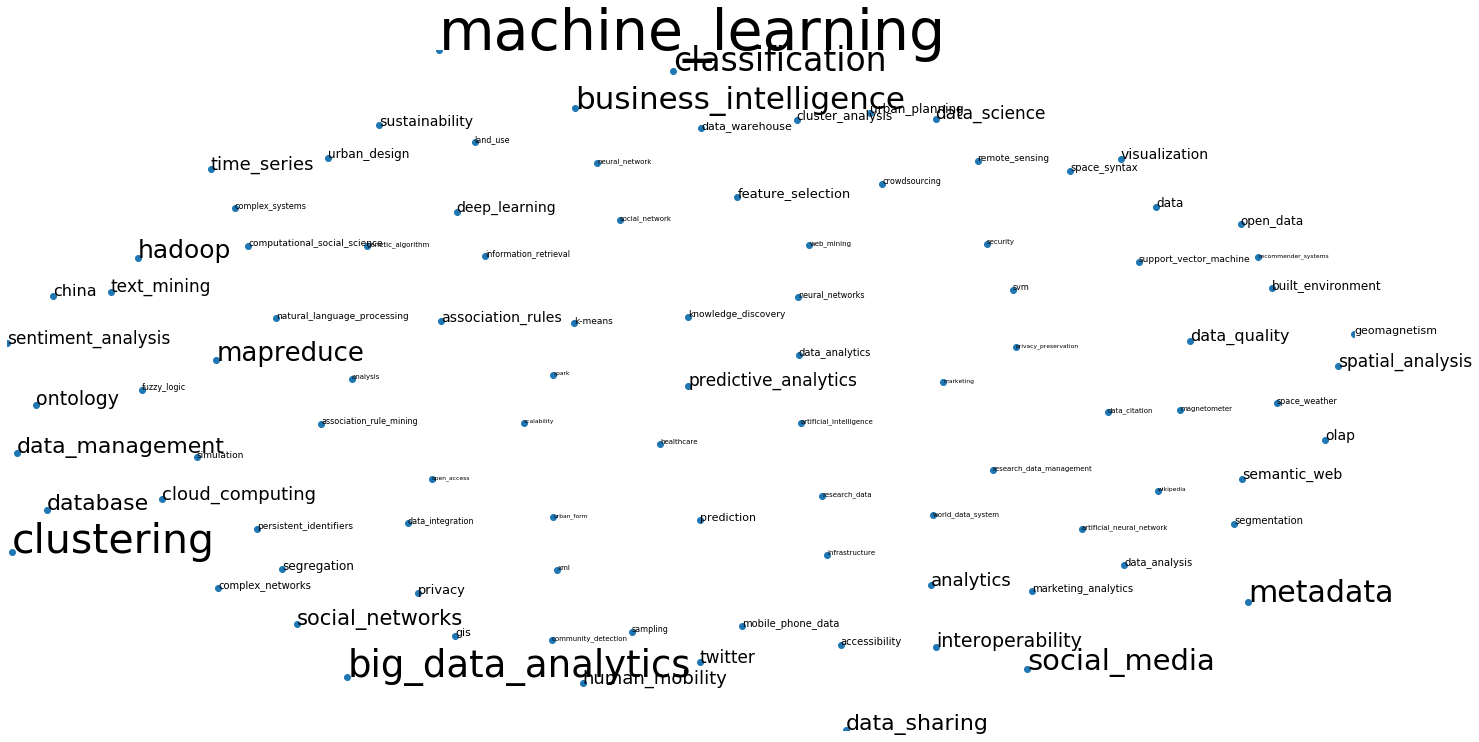

In [14]:
X=list(df_proj['Column_A'])
Y=list(df_proj['Column_B'])
labels=list(df_proj['Word'])
sizes=list(df_proj['Frequency'])
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(X, Y)

for x, y, label, size in zip(X, Y, labels, sizes):
    ax.annotate(label, (x, y), fontsize=size)
plt.axis("off")
plt.tight_layout()

plt.margins(x=0, y=0)
plt.show()